This notebook present how to use the Loyd-Max algorithm in order to optimally quantized the tofs.

 Imports

In [3]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
import h5py
from multiprocess import Pool
from tqdm import tqdm
import math

import matplotlib
matplotlib.style.use('seaborn')

import sys
sys.path.append('../')

import nonuniform_quantization

File info (modify according to your environment and dataset)

In [4]:
file_path = '/sdf/home/b/berthie/tmox42619_data/h5files/hits.tmox42619.run135.h5'
good_ports = ['port_0','port_1','port_4','port_5','port_12','port_13','port_14','port_15']

Quantizer (Choose "n", the number of bit for the quantizer)

In [5]:
n=8 
Q = nonuniform_quantization.quantizer(Nb_bits=n)

Input data

In [6]:
f = h5py.File(file_path, 'r')

raw_tofs = []
for port in good_ports:
    temp = np.asarray(f[port]['tofs'][1:])
    raw_tofs.append(temp-temp.min())      # I subtract the minimum value so it shifts the spectrum "left"

Quantizer Training 

In [7]:
with Pool(16) as p:
    pool_outputs = list(
        tqdm(
            p.imap(Q.training,
                   raw_tofs),
            total=len(good_ports)
        )
    ) 

tofs_QLvl = []
for port in range(len(good_ports)):
    tofs_QLvl.append(pool_outputs[port][:])

100%|██████████| 8/8 [03:09<00:00, 23.71s/it]


Quantization

In [8]:
quantized_tofs_cluster_assignments = []
quantized_tofs = []
for port in tqdm(range(len(good_ports))):
    quantized_tofs_temp, quantized_tofs_cluster_assignments_temp = Q.quantization(raw_tofs[port], tofs_QLvl[port], return_cluster_assignments=True)
    quantized_tofs_cluster_assignments.append(quantized_tofs_cluster_assignments_temp)
    quantized_tofs.append(quantized_tofs_temp)

100%|██████████| 8/8 [00:00<00:00, 140.21it/s]


PDF

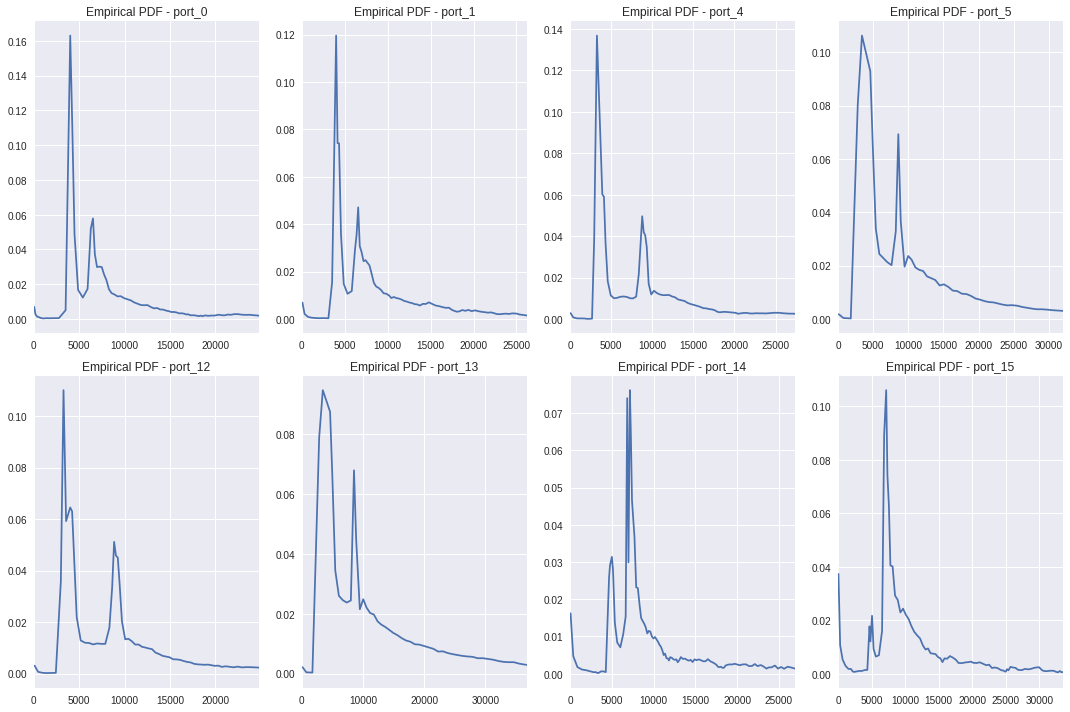

In [9]:
rows = 2
cols = 4
fig, axs = plt.subplots(rows, cols)
fig.set_figheight(10)
fig.set_figwidth(15)
port = 0
for row in range(rows):
    for col in range(cols):
        pdf, symb = Q.to_pfd(quantized_tofs[port][:])
        mean = np.mean(quantized_tofs[port][:])
        sd = np.std(quantized_tofs[port][:])
        axs[row, col].plot(symb, pdf)
        axs[row, col].set_title('Empirical PDF - ' + good_ports[port])
        axs[row, col].set_xlim([0,mean+2*sd])
        port += 1
 
plt.tight_layout()
plt.show()

Performance evaluation

In [10]:
MSQE = []
entropy_raw = []
entropy_quatized = []
for port in range(len(good_ports)):
    MSQE.append(Q.msqe(raw_tofs[port][:], quantized_tofs[port][:]))
    entropy_raw.append(Q.entropy1(raw_tofs[port][:]))
    entropy_quatized.append(Q.entropy1(quantized_tofs[port][:]))

for port in range(len(good_ports)):
    print(good_ports[port]+':')
    print('MSQE: ' + str(MSQE[port]))
    print('H (Raw): ' + str(entropy_raw[port]))
    print('H (Q): ' + str(entropy_quatized[port]))
    print('========================')

port_0:
MSQE: 6652.924226043734
H (Raw): 16.688864962997858
H (Q): 5.319546386572524
port_1:
MSQE: 5961.329396390827
H (Raw): 16.855707990729968
H (Q): 5.649355694696352
port_4:
MSQE: 9163.477800768884
H (Raw): 17.49840515054533
H (Q): 5.529800019989897
port_5:
MSQE: 25665.577579931218
H (Raw): 18.76692676985455
H (Q): 5.176310827335796
port_12:
MSQE: 8497.399439222223
H (Raw): 17.940898540943884
H (Q): 5.383130377768659
port_13:
MSQE: 30645.608254030103
H (Raw): 18.874519148365273
H (Q): 5.264468900692352
port_14:
MSQE: 3410.255595417287
H (Raw): 15.433715830688373
H (Q): 5.931716488024544
port_15:
MSQE: 8460.852793733377
H (Raw): 14.651332038441016
H (Q): 5.546294492613001


Mismatch Vizualization (Mismatch effect when using the wrong quantizer with the wrong port)

In [11]:
def highlight_diag(df):
    a = np.full(df.shape, '', dtype='<U24')
    np.fill_diagonal(a, 'background-color: red')
    return pandas.DataFrame(a, index=df.index, columns=df.columns)
    
rows = len(good_ports)
cols = len(good_ports)
msqe_mismatch_matrix = np.zeros((rows,cols))

for port_row in range(rows):
    for port_col in range(cols):
        msqe_mismatch_matrix[port_row, port_col] = int(Q.msqe(raw_tofs[port_row][:], Q.quantization(raw_tofs[port_row][:], tofs_QLvl[port_col][:])))

tofs_list = []
qtz_list = []
for port in good_ports:
    tofs_list.append('tofs_' + port)
    qtz_list.append('qtz_' + port)
    
df = pandas.DataFrame(msqe_mismatch_matrix, tofs_list, qtz_list, dtype=int)
df.style.apply(highlight_diag, axis=None)

,qtz_port_0,qtz_port_1,qtz_port_4,qtz_port_5,qtz_port_12,qtz_port_13,qtz_port_14,qtz_port_15
tofs_port_0,6652,9934,18560,83172,13796,90019,9269,17286
tofs_port_1,57500,5961,159933,76131,32738,82602,19449,15767
tofs_port_4,24977,17029,9163,54367,9787,59524,28381,16616
tofs_port_5,68541,45376,180264,25665,29507,30056,46251,30209
tofs_port_12,20372,14413,20074,50097,8497,55337,11801,15850
tofs_port_13,74496,53666,219745,26717,31629,30645,50746,48555
tofs_port_14,317694,28568,1033318,28148,146463,30879,3410,50042
tofs_port_15,610295,83084,2484575,29260,206733,33404,46910,8460


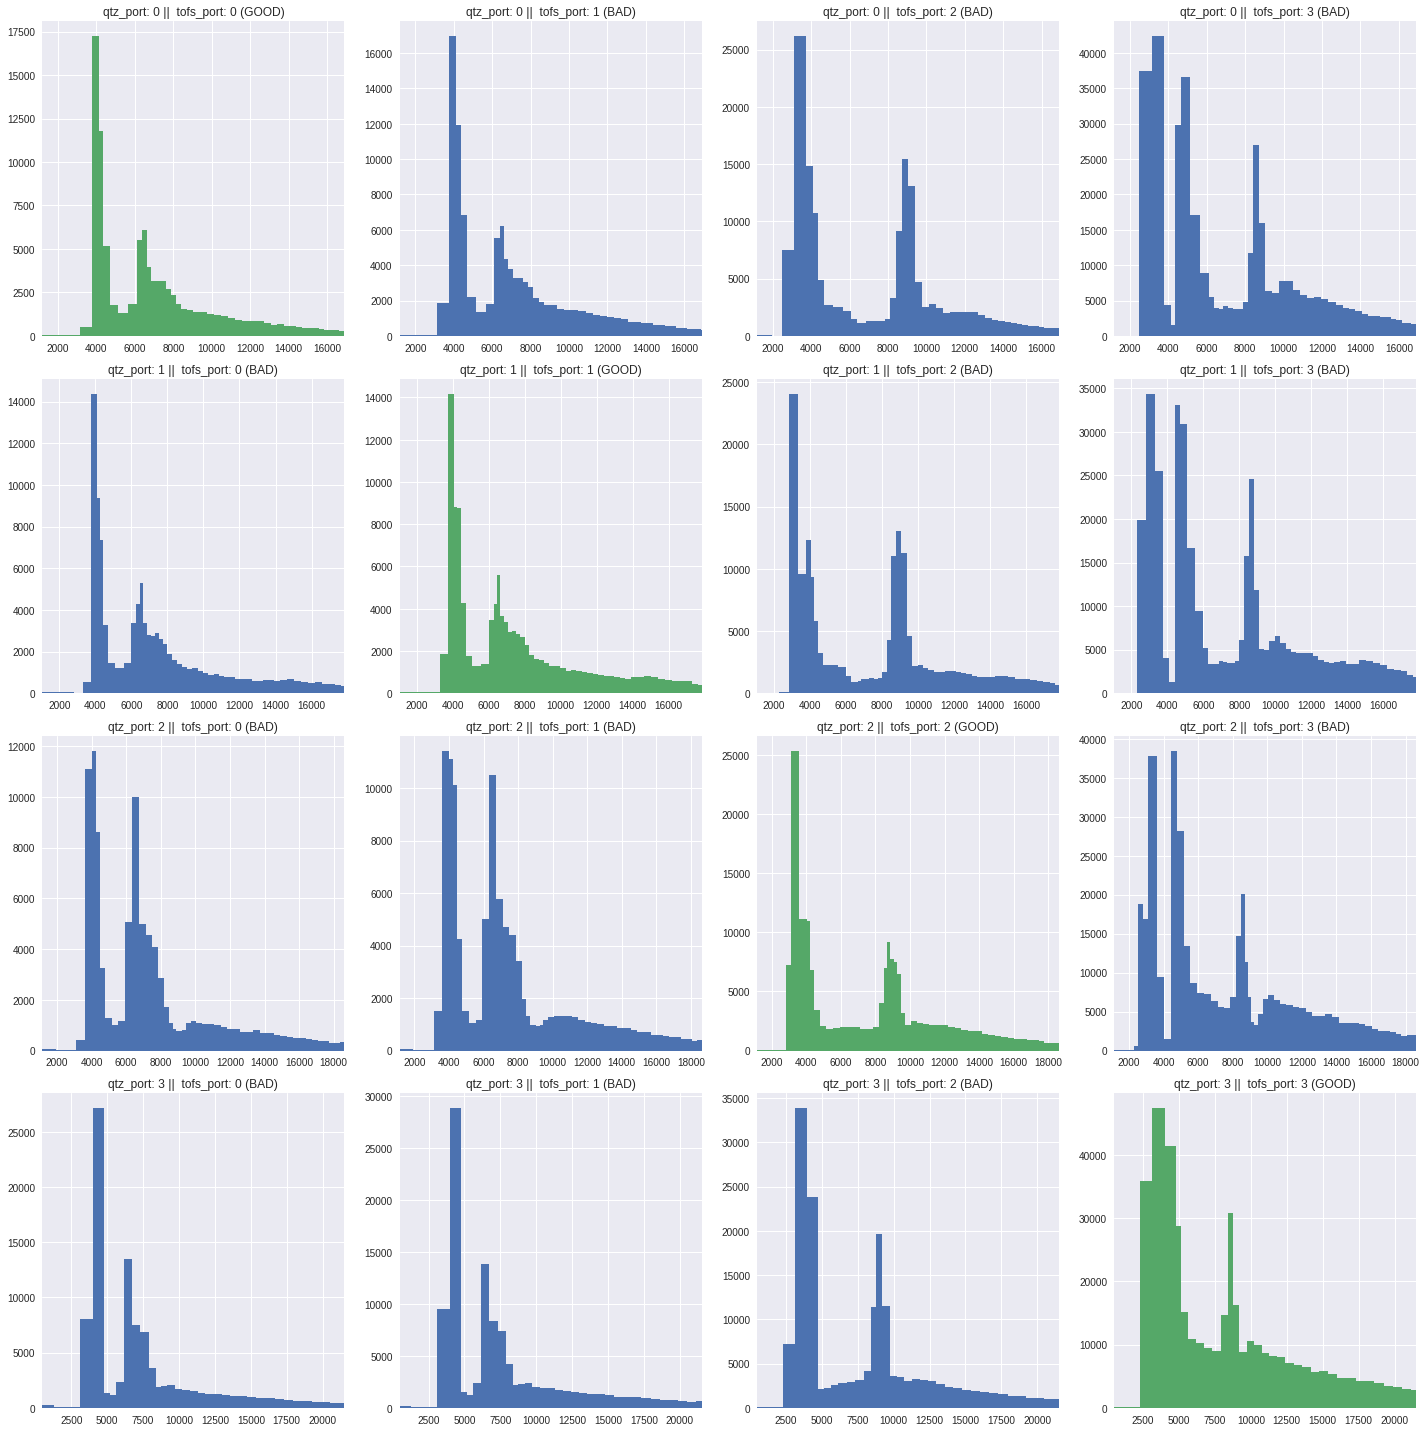

In [12]:
rows = 4
cols = 4
fig, axs = plt.subplots(rows, cols)
fig.set_figheight(20)
fig.set_figwidth(20)

for port_row in range(rows):
    mean = np.mean(raw_tofs[port_row][:])
    sd = np.std(raw_tofs[port_row][:])
    bin_edges = (tofs_QLvl[port_row][:-1] + tofs_QLvl[port_row][1:]) / 2

    for port_col in range(cols):
        if port_row == port_col:
            axs[port_row, port_col].hist(raw_tofs[port_col][:], bins=bin_edges,color='C1')
            axs[port_row, port_col].set_title('qtz_port: ' + str(port_row) + ' ||  tofs_port: ' + str(port_col) + ' (GOOD)')
        else:
            axs[port_row, port_col].hist(raw_tofs[port_col][:], bins=bin_edges,color='C0')
            axs[port_row, port_col].set_title('qtz_port: ' + str(port_row) + ' ||  tofs_port: ' + str(port_col) + ' (BAD)')
            
        axs[port_row, port_col].set_xlim([mean-sd,mean+sd])
        

plt.tight_layout()
plt.show()

Making heatmaps/sinograms

In [13]:
Nb_QLvl = int(2**n)

hist = np.zeros((len(f[good_ports[0]]['addresses']), len(good_ports), Nb_QLvl))

for port in tqdm(range(len(good_ports))):
    for ind, offset in enumerate(f[good_ports[port]]['addresses']):   
        nhits = f[good_ports[port]]['nedges'][ind]
        temp = quantized_tofs_cluster_assignments[port][offset:offset+nhits]
        for i in range(len(temp)):
            hist[ind ,port, temp[i]] += 1


100%|██████████| 8/8 [01:34<00:00, 11.82s/it]


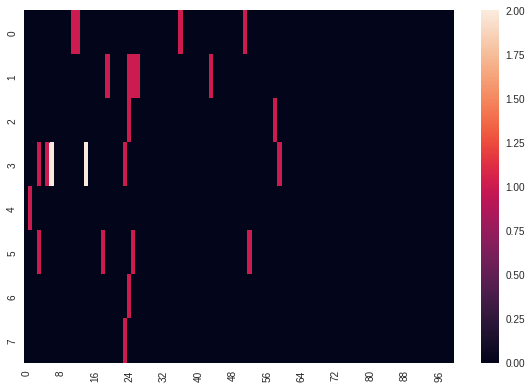

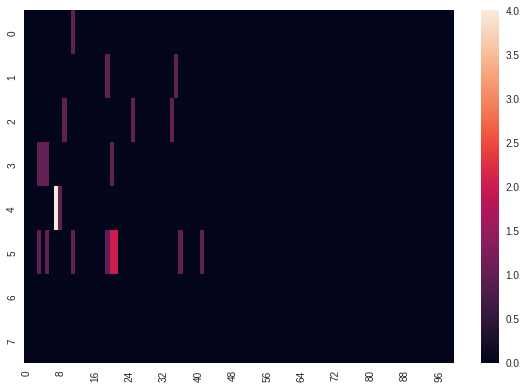

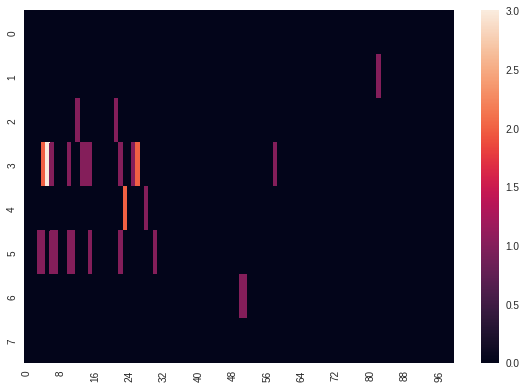

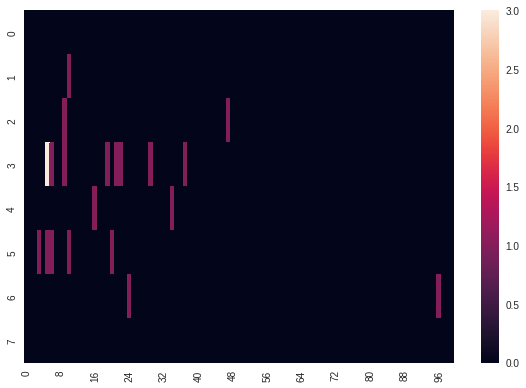

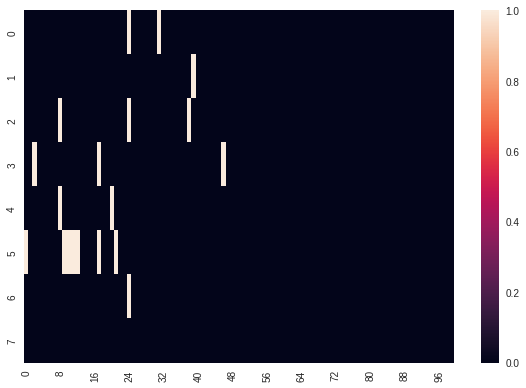

In [14]:
import seaborn as sns

for i in range(5):
    ax = sns.heatmap(hist[i])
    plt.xlim([0,100])
    plt.tight_layout()
    plt.show()



 * MIT License
 *
 * Copyright (c) 2022 SLAC National Accelerator Laboratory
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in all
 * copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
 * SOFTWARE.
 *
 * Authors : Berthié Gouin-Ferland
 * Last update : 2022-12-06
 *
 * Description : This notebook describes the quantization method.
